<a href="https://colab.research.google.com/github/claudia-viaro/optimal_stopping-switching/blob/main/optimal_stopping/Copy_of_optimal_stopping_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Formulation
Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options) that influence the production of power. Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t^i = (b-\delta_i)dt + \sigma_i dW_t^i
\end{equation}
where $W$ is a standard Brownian otion on a filtered probability space $(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \geq 0}, \mathbb{P})$ and $b$, $d_i$, $\sigma_i >0$ are the drift. dividend yield and volatility of the system at time $t$.

We will consider a discrete time approximization (Euler schema) on an equidistant time grid $0=t_0 < t_1 < \ldots < t_N = T$, where $t_n = n \cdot T/N$. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
x^p_{n,i} = x_{0,i} \cdot \exp \Big\{ \sum_{k=0}^n \big( (b-\delta_i - \sigma^2_i /2)\Delta t + \sigma_{i} \sqrt{\Delta t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\Delta t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.



In [62]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata
from google.colab import files
import helper

In [63]:
class BlackScholes:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths, self.assets ))

    spot_paths[0, :, :] = self.spot
    random_numbers = np.random.normal(
        0, 1, (self.periods, paths, self.assets ))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), self.periods, axis=0),
        paths, axis=1), self.assets, axis=2)
    sig = np.ones((self.periods, paths, self.assets))*self.sigma
    #sig = np.repeat(np.repeat(np.repeat(
    #    np.reshape(self.sigma, (-1, 1, 1)), self.periods+1, axis=2),
    #    paths, axis=1), self.assets, axis=0)
    
    spot_paths[1:, :,  :] = np.repeat(
        spot_paths[0:1, :, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])

In [64]:
def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

# Class "Payoff"
This class specifies the payoff (some alternatives) that is received when selling/buying the option. 

- MaxCall
\begin{equation}
\pi(n) = \Big(\max_{d \in \{1, \ldots, D \}} x_n^d - K   \Big)^{+} \tag{1}
\end{equation}
where $K$ is the strike price

In [65]:
'''
PAYOFF
'''
class Payoff_:
  def __init__(self, model):
    self.strike = model.strike
    self.model = model

  
  def MaxCall_(self, n, X): # already get tensor
    a = torch.tensor(())
    for m in range(0, self.model.paths):
      date = n[m]
      tensorX= torch.from_numpy(X[int(date),m,:])
      max1=torch.max(tensorX-100)  
      i = torch.tensor([max1]).float()
      a = torch.cat((a, i), 0)
    return a

# Class "Ftheta_NN"

We employ a neural network to approximate the stopping decision functions $\{f_n\}_{n=0}^N$ by constructing a sequence of neural networks of the form $f^{\theta_n}:\mathbb{R}^d → \{0,1\}$ with parameters $\theta_n \in \mathbb{R}^q$ to approximate $f_n$.

The neural network used here takes the form $F^{\theta}: \mathbb{R}^d → (0,1)$ for $\theta \in \{\theta_0, \ldots, \theta_N  \}$, that is the parameters are trained via a neural network that outputs probabilities in the interval $(0,1)$. This is due to the fact that the G-B optimization algorithm is to be applied to a continuous function with respect to $\theta_n$, which $f^{\theta_n}$ is not. Hence, the multi-layer, feed-forward neural network takes the form:

\begin{equation}
F^{\theta}= \psi \circ a_3^{\theta} \circ \phi_{q_2} \circ a_2^{\theta} \circ \phi_{q_1} \circ a_1^{\theta}
\end{equation}
where 

-  $q_1, q_2$ are the number of nodes in the hidden layers
- $a_1^{\theta} : \mathbb{R}^d → \mathbb{R}^{q_1}, a_2^{\theta}: \mathbb{R}^{q_1} → \mathbb{R}^{q_2}$ are linear transformation functions: $a_i^{\theta}(x)=W_i x + b_i$ with matrices $W_1 \in \mathbb{R}^{q_1 \times d}, W_2 \in \mathbb{R}^{q_2 \times q_1}, W_3 \in \mathbb{R}^{q_2 \times 1}$ and vectors $b_1 \in \mathbb{R}^{q_1}, b_2 \in \mathbb{R}^{q_2}, b_3 \in \mathbb{R}^{1}$.
- $\phi_{q_i}: \mathbb{R}^{q_i}$ is the ReLU activation function: $\phi_{q_1}(x_i, \ldots, x_{q_i})=(x_i^{+}, \ldots, x_{q_i}^{+})$
- $\psi = \mathbb{R} → \mathbb{R}$ is the logistic sigmoid function: $\psi(x)=1/(1+ e^{-x})$.
Between the layers a batch normalization is also added, it takes the output from the previous layer and normalizes it before sending it to the next layer. This has the effect of stabilizing the neural network. 

The parameters will comprise $\theta = \{W_1, W_2,, W_3, b_1, b_2, b_3\}\in \mathbb{R}^q$, where $q=q_1(d+q_2+1)+2q_2+1$. The value of $d$ stands for the dimension, that is the number of assets and will be varied among $d=\{2,4, 5, 10, 20\}$. 


In [66]:
'''
Neural network
'''

class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.a1 = nn.Linear(assets, H)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.a2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.a3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    out = self.bn0(input)
    out = self.a1(out)
    out = self.relu(out)
    #out = self.bn1(out)
    #out = self.a2(out)    
    #out = self.relu(out)
    out = self.bn2(out)
    out = self.a3(out)    
    out = self.sigmoid(out)
    return out

# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01) 

# Class "Training_network"

The NN is used to approximate the optimal stopping decisions $f_n: \mathbb{R}^d \rightarrow \{0, 1 \}$, $n = \{ 1, \ldots, N-1 \}$, at each date by a neural network $f^{\theta}: \mathbb{R}^d \rightarrow \{0, 1 \}$ with parameter $\theta \in \mathbb{R}^q$. 

We choose $\theta_N \in \mathbb{R}^q$ such that $f^{\theta}_N \equiv 1$ and determine $\theta_n \in \mathbb{R}^q$ for $n \leq N-1$ by recursion of the form:

\begin{equation}
\tau_{n+1} = \sum_{m=n+1}^N m f^{\theta_m}(X_m) \prod _{j=n+1}^{m-1} (1-f^{\theta_j}(X_j))
\end{equation}

Since $f^{\theta}$ takes values in $\{ 0,1 \}$, hence not appropriate for a gradient-descent optimization method, the neural network includes a layer performing a logistic transformation such that we have a continuous output function $F^{\theta}: \mathbb{R}^d \rightarrow (0,1)$.

At each time step, for each epoch we compute $F^{\theta_n}$ using the $\theta_n$ from the previous epoch. Then, the parameter $\theta_n$ is update via backpropagation by the gradient of the loss function (Adam optimization algorithm \citep{kingma2014adam}), which is specified as:

\begin{equation}
    Loss = - \mathbb{E}[g(n, X_n)F^{\theta_n}(X_n) + g(\tau_{n+1}, X_{\tau_{n+1}})(1-F^{\theta_n}(X_n))]
\end{equation}

The aim is to determine $\theta_n \in \mathbb{R}^q$ so that the negative of the loss function is close to the supremum $\sup_{\theta \in \mathbb{R}^q}\mathbb{E}[g(n, X_n)F^{\theta}(X_n) + g(\tau_{n+1}, X_{\tau_{n+1}})(1-F^{\theta}(X_n))   ]$. 

Looking at the formula for the loss function, it takes as inputs:
- _current payoff:_ payoff of the option computed at time $n$ for all paths if it is exercised at time $n$. this is the value of the option at time $n$ when it is exercised
- _future payoff:_ expected value of the future payoff, computed at a stopping time observed in the future ($\tau+1$), this is the value of the option at time $n$ when it is not exercised (continuation value)

The NN takes as inputs:
- _stock prices:_ the prices of the stock at time $n$ across multiple paths

and as outputs:
- values in $\{ 0,1 \}$, representing the probability of stopping the process (exercising the option). 

In [67]:
class Training_network(object):

  def __init__(self, assets,  epochs=400, batch_size=2000):
    self.assets = assets
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = Ftheta_NN(self.assets).double()
    self.network.apply(init_weights)

  # training part
  def train_network(self,  stock_values, current_payoff,
                    future_payoff):
        
    # several optimization methods are available (here Adam algorithm). as argument input the parameters to be optimized    
    optimizer = optim.Adam(self.network.parameters())
    
    # set values for the NN inputs (stock_values) 
    X_inputs = torch.from_numpy(stock_values).double() 

    # set values for the loss
    # current_payoff, future_payoff are already tensors
    ones = torch.ones(len(future_payoff)) # we need a vector of 1's in the loss function

    self.network.train(True) # set training mode ON    
    losses = []
    
    for epoch in range(self.epochs):
      running_loss = 0.0
      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          F_theta = self.network.forward((X_inputs[batch])).reshape(-1) 
          reward = (current_payoff[batch].reshape(-1)* F_theta + 
                    future_payoff[batch] * (ones[batch] - F_theta)) 
          
          # compute loss function
          loss = -torch.mean(reward)
          
          # compute gradients
          loss.backward()
          # take a step, updating the parameters 
          optimizer.step()

          running_loss += loss.item() * self.batch_size
      epoch_loss = running_loss /  len(tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False).sampler)
      losses.append(epoch_loss)          
    
    # I would like to retain params computed at each each date so that I can access them later
    torch.save(self.network.state_dict(), 'checkpoint.pth') 

    return F_theta, self.network, losses  
  
  # function to inform the NN to perform a testing phase
  def evaluate_network(self, X_inputs):
    state_dict = torch.load('checkpoint.pth')
    self.network.load_state_dict(state_dict)

    self.network.eval()
    X_inputs = torch.from_numpy(X_inputs).double()
    
    # the output is a probability for each date and path
    # it is obtained by feeding the NN with the dimension of the assets (at a specific date for all paths), 
    outputs = self.network(X_inputs)
    return outputs.view(X_inputs.size()).detach().numpy()

#Training

We conduct $3000+d$ training steps and for each we generate a batch of $8192$ paths of $(X_n)_{n=0}^N$.

The resulting output will be 
- the stopping decisions $f_n: \mathbb{R}^d \rightarrow \{0, 1 \}$, $n = \{ 1, \ldots, N-1 \}$
- ideally the parameters $\theta_n$ 


In [68]:
# simulate paths 
hyperparam_training = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':4, 'periods': 9, 'maturity': 1., 'strike' : 100,'assets':2,  'spot':90,}
S_train=BlackScholes(**hyperparam_training)

# Class "Training"

This is a recursion. It starts by initializing:
- model, that is the simulated stock prices
- payoff class
- NN **too early? should it go at every time step instead**

Create some matrices to store values that will be accessed to at different time steps
- _mods_ records the models at each time step, basically it appends, by date, the networks (not sure if it is enough to say that it stores the optimized parameters)
- _loss functions_ just to plot
- _tau dates:_ it is a matrix $(n \times m)$, it records for each date when there is a stopping time (can only be at such date or higher)
- _F theta:_ it is a matrix $(n \times m)$, it records the outputs of the NN (0,1 values), only used to obtain the tau_dates

The backward induction goes as:
1. at maturity
  - compute the terminal payoff
  - no need to compute the stopping times/stopping decision functions because by construction $f_N \equiv 1$
  - hence set F_theta[N,:]=1 and tau_dates[N,:]=N

2. before maturity
- compute values for training the NN, hence current payoff $g(n, X_n)$ and future payoff $g(\tau_{n+1}, X_{\tau_{n+1}})$. The future payoff needs as time variable $\tau_{n+1}$, we get it from the matrix tau_dates, taking value at $n+1$. The future payoff, as it refers to a value at time $\tau_{n+1}$, needs to be discounted to $n$ **not done well here, just one timestep**
- feed in the values in the function neural_stopping.train_network()
- using the outputs returned by this function, we record values in matrices F_theta and tau_dates

This is repeated until $n=1$

In [69]:
class Training:
  def __init__(self, model, payoff_function):

    self.model = model
    self.payoff = payoff_function(self.model)
    self.neural_stopping = Training_network(self.model.assets)

  def value(self):
    model = self.model
    stock_paths = self.model.simulate_process()  
    disc_factor = np.exp(-model.drift*model.maturity/model.periods)

    # lists to store some values
    mods=[None]*model.periods # record the models of the NN for testing
    loss_functions = [None]*model.periods # record loss
    tau_dates=np.zeros((model.periods+1,model.paths)) # record stopping times
    tau_dates[model.periods,:]=model.periods    
    F_theta_train=np.zeros((model.periods+1,model.paths))
    
    
    # AT MATURITY N
    final_dates =  tau_dates[model.periods,:]
    terminal_payoff = self.payoff.MaxCall_(final_dates, stock_paths) # payoff of the last date

    tau_dates[model.periods,:]=model.periods   
    F_theta_train[model.periods,:]=1
    print("date", model.periods, ",", model.paths)
 

    # from n=N-1 to 0 with steps of -1

    for date in range(stock_paths.shape[0] - 2, 0, -1):      
      tau_date_plus_one = tau_dates[date+1, :]
      
      continuation_value =  self.payoff.MaxCall_(tau_date_plus_one, stock_paths)
      current_value =  self.payoff.MaxCall_([date]*model.paths, stock_paths)
      
      stopping_rule , networks, loss = self.neural_stopping.train_network(stock_paths[date, : , :], 
                                                  current_value,
                                                  continuation_value*disc_factor)
      mods[date]=networks
      loss_functions[date]=loss
      F_theta_train[date,:]=(stopping_rule > 0.5)*1.0 
      tau_dates[date,:]=np.argmax(F_theta_train, axis=0)

      print("date", date, ",", len([1 for l in stopping_rule if l > 0.5]), " mean reward ", np.mean(loss))
      

    return mods, loss_functions

  def stop(self, stock_values, current_payoff, future_payoff, train=True):
    if train:
      stopping_probability, networks, losses = self.neural_stopping.train_network(stock_values,
                                                                          current_payoff,
                                                                          future_payoff)
      #inputs = stock_values
      #stopping_probability , networks   = self.neural_stopping.evaluate_network(inputs)
    return stopping_probability, networks, losses  

In [70]:
pricing = Training(S_train, Payoff_)
mods, loss_function = pricing.value()

date 9 , 4
date 8 , 1  mean reward  -410.89122656546454
date 7 , 1  mean reward  -456.1365419222771
date 6 , 0  mean reward  39.619219287532644
date 5 , 0  mean reward  28.256825765957046
date 4 , 0  mean reward  28.995807532518437
date 3 , 0  mean reward  27.858496023455718
date 2 , 0  mean reward  27.814188397098743
date 1 , 0  mean reward  27.81380791551791


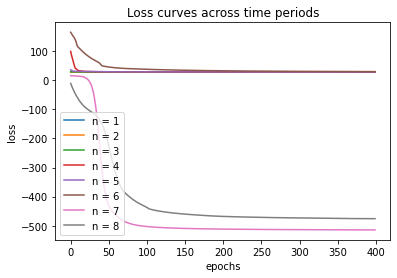

In [71]:
filtered_list = list(filter(None, loss_function))
legend = ["n = 1", "n = 2", "n = 3", "n = 4", "n = 5", "n = 6", "n = 7", "n = 8"]

for i in range(len(filtered_list)):
  epochs = np.array([i for i in range(len(filtered_list[0]))])
  plt.plot(epochs, filtered_list[i], label='loss funciton')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(legend)
  plt.title('Loss curves across time periods')
  plt.plot()


In [72]:
'''
class Payoff_:
  def __init__(self, model):
    self.strike = model.strike
    self.model = model

  def MaxCall(self, X):
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)

  
  def MaxCall_(self, n, X): # already get tensor
    a = torch.tensor(())
    for m in range(0, self.model.paths):
      date = int(n[m])
      tensorX= torch.from_numpy(X[date,m,:])
      max1=torch.max(tensorX-100)  
      i = torch.tensor([max1]).float()
      a = torch.cat((a, i), 0)
    return a

'''    


def loss(y_pred,S, X, n, tau): # input tau is tau_mat_test[date+1]
    payoff = Payoff_(model)
    r_n=torch.zeros((S.paths))
    for m in range(0,S.paths):

        r_n[m]=-(payoff.MaxCall(n,m,X)*y_pred[m] + payoff.MaxCall(tau[m],m,X)*(1-y_pred[m]))
    
    return(r_n.mean())

'''
# CHECK TRAINING

# check training
hyperparam_training = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':7, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':2,  'spot':90,}
model=BlackScholes(**hyperparam_training)
neural_stopping = Training_network(model.assets)
stock_paths = model.simulate_process()    
disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))

payoff = Payoff_(model)
# some objects
mods=[None]*model.periods
tau_dates=np.zeros((model.periods+1,model.paths)) # record stopping times
tau_dates[model.periods,:]=model.periods
loss_functions = [None]*model.periods # record loss
F_theta_train=np.zeros((model.periods+1,model.paths))
F_theta_train[model.periods,:]=1
    
    
# AT MATURITY N

terminal_payoff = payoff.MaxCall_(tau_dates[model.periods,:], stock_paths) # payoff of the last date
#print("terminal_payoff", terminal_payoff)
print("tau end", tau_dates[model.periods,:])
m=1
b = torch.tensor(())
n=tau_dates[model.periods,:]
print("n", n)
date = n[m]
print("date", date)
tensorX= torch.from_numpy(stock_paths[int(date),m,:])
max1=torch.max(tensorX-100)  
print("max1", max1)

# recursive calc. before maturity
date = stock_paths.shape[0] - 2
tau_date_plus_one = tau_dates[date+1, :]
print("tau_date_plus_one", tau_date_plus_one)
date1 = int(tau_date_plus_one[m])
print(date1)

continuation_value =  payoff.MaxCall_(tau_date_plus_one, stock_paths)
current_value =  payoff.MaxCall_([date]*model.paths, stock_paths)
print([date]*model.paths)
#print("continuation_value", continuation_value)
print("current_value", current_value)

a = torch.tensor(())
for m in range(0, model.paths):
  date = int(tau_date_plus_one[m])
  tensorX= torch.from_numpy(stock_paths[date,m,:])
  max1=torch.max(tensorX-100)  
  i = torch.tensor([max1]).float()
  a = torch.cat((a, i), 0)
print("a", a)

X_inputs = torch.from_numpy(stock_paths[date, : , :]).double() # input to the NN must be a tensor

print(X_inputs.shape) # 7 paths, 2 assets for that date
#print("X_inputs", X_inputs)



stopping_rule , networks, loss = neural_stopping.train_network(stock_paths[date, : , :], 
                                                  current_value,
                                                  continuation_value*disc_factor)
mods[date]=networks
loss_functions[date]=loss
print("date", date, ",", len([1 for l in stopping_rule if l > 0.5]), " mean loss ", np.mean(loss))
print(stopping_rule.shape)
F_theta_train[date,:]=(stopping_rule > 0.5)*1.0 
#print(F_theta_train[date,:])
tau_dates[date,:]=np.argmax(F_theta_train, axis=0)
#print(tau_dates[date,:].shape)

#print(tau_dates)

'''

'\n# CHECK TRAINING\n\n# check training\nhyperparam_training = {\'drift\': 0.2, \'sigma\': 0.05, \'delta\': 0.1,  \'paths\':7, \'periods\': 9, \'maturity\': 3., \'strike\' : 100,\'assets\':2,  \'spot\':90,}\nmodel=BlackScholes(**hyperparam_training)\nneural_stopping = Training_network(model.assets)\nstock_paths = model.simulate_process()    \ndisc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))\n\npayoff = Payoff_(model)\n# some objects\nmods=[None]*model.periods\ntau_dates=np.zeros((model.periods+1,model.paths)) # record stopping times\ntau_dates[model.periods,:]=model.periods\nloss_functions = [None]*model.periods # record loss\nF_theta_train=np.zeros((model.periods+1,model.paths))\nF_theta_train[model.periods,:]=1\n    \n    \n# AT MATURITY N\n\nterminal_payoff = payoff.MaxCall_(tau_dates[model.periods,:], stock_paths) # payoff of the last date\n#print("terminal_payoff", terminal_payoff)\nprint("tau end", tau_dates[model.periods,:])\nm=1\nb = torch.tensor(())\n

#Lower bound

the stopping time $\tau^{\Theta}$ gives a lower bound $L=\mathbb{E}g(\tau^{\Theta}, X_{\tau^{\Theta}})$ for the optimal value $V_0= \sup_{\tau \in \mathcal{T}}\mathbb{E}g(\tau, X_{\tau})$.

Simulate 
- $K_L = 1024$ paths $(y_n^k)_{n=0}^N$, $k=1, \ldots, K_L$, of $(X_n)_{n=0}^N$ and assume these are drawn independently from the realizations $(x_n^k)_{n=0}^N$, $k=1, \ldots, K$.

The unbiased estimate of the lower bound $L$ is given by
\begin{equation}
\hat{L}=\frac{1}{K_L} \sum_{k=1}^{K_L} g(l^k, y_{l^k}^k)
\end{equation}
where $l^k = l(y_0^k, \ldots, y_{N-1}^k)$

In [73]:
# Testing phase - Lower bound

# sample y from the process (Y)
hyperparam_testing_L = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':40, 'periods': 9, 'maturity': 1., 'strike' : 100,'assets':2,  'spot':90,}
S_test_L=BlackScholes(**hyperparam_testing_L)

# now we can compute all the stopping times recursively

In [74]:
'''

model = S_test_L
stock_paths = model.simulate_process()
date = stock_paths.shape[0] - 2

mod_curr = mods[date]     
probs=mod_curr(torch.from_numpy(stock_paths[date])) 
np_probs=probs.detach().numpy().reshape(model.paths)     
which = np_probs > 0.5
print(which)

neural_stopping = Training_network(model.assets, model.paths)
stopping_probability , networks   = neural_stopping.evaluate_network(stock_paths[date])
print(stopping_probability  > 0.5)
'''

'\n\nmodel = S_test_L\nstock_paths = model.simulate_process()\ndate = stock_paths.shape[0] - 2\n\nmod_curr = mods[date]     \nprobs=mod_curr(torch.from_numpy(stock_paths[date])) \nnp_probs=probs.detach().numpy().reshape(model.paths)     \nwhich = np_probs > 0.5\nprint(which)\n\nneural_stopping = Training_network(model.assets, model.paths)\nstopping_probability , networks   = neural_stopping.evaluate_network(stock_paths[date])\nprint(stopping_probability  > 0.5)\n'

In [75]:
# Testing

class Testing_Lower:
  def __init__(self, model, payoff, mods):   
    self.model = model # argument is S   
    self.payoff = payoff(self.model)
    #self.neural_stopping = Training_network(self.model.assets)
    self.mods = mods



  def price(self):
    model = self.model    
    stock_paths = self.model.simulate_process()
    
 
    # at maturity N
    final_payoff = self.payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
    payoff_0 = self.payoff.MaxCall(stock_paths[0, :, :])  
    values = final_payoff
    print("date", model.periods, ":", 1.0," , ", 1.0, " , ", model.paths, "value", round(np.mean(values), 3))


    # recursive calc. before maturity
         
    for date in range(stock_paths.shape[0] - 2, 0, -1):
      current_payoff = self.payoff.MaxCall(stock_paths[date, :, :])
      mod_curr=self.mods[date]

      #probs = self.neural_stopping.evaluate_network(stock_paths[date, : , :])
      
      probs=mod_curr(torch.from_numpy(stock_paths[date, :, :])) 
      np_probs=probs.detach().numpy().reshape(self.model.paths)     
      which = np_probs > 0.5

      values[which] = current_payoff[which]
      values[~which] *= (np.math.exp((-model.drift) * (model.periods-date)/model.periods))
      print("date", date, ":", round(np.min(np_probs), 3)," , ", round(np.max(np_probs), 3), " , ", len([1 for l in np_probs if l > 0.5]), "value", round(np.mean(values), 3))

    
    return round(payoff_0[0], 3), round(np.mean(values)*(np.math.exp((-model.drift) * (date/model.periods))) , 3)



In [76]:
price_testing = Testing_Lower(S_test_L, Payoff, mods)

Y_test_mean, MC_estimate = price_testing.price()
print(Y_test_mean, MC_estimate)

date 9 : 1.0  ,  1.0  ,  40 value 2.559
date 8 : 0.0  ,  0.0  ,  0 value 2.503
date 7 : 0.0  ,  0.0  ,  0 value 2.394
date 6 : 0.0  ,  0.0  ,  0 value 2.24
date 5 : 0.0  ,  0.0  ,  0 value 2.049
date 4 : 0.0  ,  0.0  ,  0 value 1.834
date 3 : 0.0  ,  0.0  ,  0 value 1.605
date 2 : 0.0  ,  0.0  ,  0 value 1.374
date 1 : 0.0  ,  0.0  ,  0 value 1.15
0.0 1.125


# Upper Bound

For every $(\mathcal{F}_n)$-martingale $(M_n)_{n=0}^N$ starting from $0$ and each sequence of integrable error terms $(\epsilon_n)_{m=0}^N$ satisfying $\mathbb{E}[\epsilon_n | \mathcal{F}_n]=0$ for all $n$, the following expression provides an upper bound for $V_0$, which is also tight if $M=M^H$ and $\epsilon \equiv 0$.
\begin{equation}
U = \mathbb{E} \Big[ \max_{0 \leq n \leq N} [g(n, X_n) - M_n^{\Theta} - \epsilon_n ]  \Big]
\end{equation}


We need an expression for $M^H$ and use the Doob-Meyer decomposition on the Snell envelope of the reward process:
\begin{equation}
H_n = \text{ess} \sup_{\tau \in \mathcal{T}_n} \mathbb{E}[g(\tau)| \mathcal{F}_n], \;\;\;\ n=0, 1, \ldots, N
\end{equation}
where its Doob-Meyer deomposition is given by:
\begin{equation}
H_n = H_0 + M_n^H - A_n^H
\end{equation}
and
\begin{equation}
M_0^H = 0\;\;\;\; \text{and} \;\; M_n^H-M_{n-1}^H=H_n-\mathbb{E}[H_n | \mathcal{F}_{n-1}], \;\;\; n=1, \ldots, N
\end{equation}



We use $\tau^{\Theta}$ to construct a martingale close to $M^H$. The martingale part of $(H_n^{\Theta})_{n=0}^N$ is given by:
\begin{equation}
\begin{split}
&M_0^{\Theta}\\
&M_N^{\Theta}- M_{n-1}^{\Theta} = H_n^{\Theta}-\mathbb{E}[H_n^{\Theta} | \mathcal{F}_{n-1}] = f^{\theta_n}(X_n)g(n, X_n) + (1- f^{\theta_n})) C_n^{\Theta}-C_{n-1}^{\Theta}, \;\; n \geq 1
\end{split}
\end{equation}
and the continuation value is:
\begin{equation}
C_n^{\Theta}=\mathbb{E}[g(\tau_{n+1}^{\Theta}, X_{\tau_{n+1}^{\Theta}})| \mathcal{F}_n] = \mathbb{E}[g(\tau_{n+1}^{\Theta}, X_{\tau_{n+1}^{\Theta}})| X_n], \;\;\;\ n=0, 1, \ldots, N-1
\end{equation}
there is no need to specify $C_N^{\Theta}$ because $(1- f^{\theta_N}(X_N))$ is always $0$.


Simulate 
- $K_U = 1024$ paths $(z_n^k)_{n=0}^N$, $k=1, \ldots, K_U$, of $(X_n)_{n=0}^N$
- $K_U \times J$ realizations $(v_n^{k,j})_{n=0}^N$, $k=1, \ldots, K_U$, $j=1, \ldots, J$, of $(W_{t_n} - W_{t_n - 1})_{n=1}^N$ with $J=16384$
- for all $n$ and $k$, generate the $i$-th component of the $j$-th continuation path departing from  $z_n^k$ according to:
\begin{equation}
\tilde{z}_n^{i,k,j}=z_n^{i,k} \exp \Big([r- \delta_i - \sigma_i^2 /2] (m-n)\Delta t + \sigma_i [v_{n+1}^{i,k,j} + \ldots, v_{m}^{i,k,j}]  \Big), \;\;\;\; m=n+1, \ldots, N
\end{equation}
we assume that $\tilde{z}_{n+1}^{k,j}, \ldots, \tilde{z}_{N}^{k,j}$ are conditionally independent of each other and of $z_{n+1}^{k}, \ldots, z_{N}^{k}$ 


In [77]:
# Testing phase - Upper bound

# sample Z from the process (X)
hyperparam_testing_U = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':1024, 'periods': 4, 'maturity': 3., 'strike' : 100,'assets':1,  'spot':90,}
S_test_U=BlackScholes(**hyperparam_testing_U)
stock_paths = S_test_U.simulate_process()
print(stock_paths.shape) #(5, 1024, 1)

(5, 1024, 1)


In [78]:
# need to generate v values

class Zvalues:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths))

    spot_paths[0, :] = self.spot
    random_numbers = np.random.normal(
        0, 1, (self.periods, paths))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(
        np.reshape(drift, (-1, 1)), self.periods, axis=0),
        paths, axis=1)
    sig = np.ones((self.periods, paths))*self.sigma
    #sig = np.repeat(np.repeat(np.repeat(
    #    np.reshape(self.sigma, (-1, 1, 1)), self.periods+1, axis=2),
    #    paths, axis=1), self.assets, axis=0)
    
    spot_paths[1:, :] = np.repeat(
        spot_paths[0:1, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])

In [79]:
hyperparam_V = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':7, 'periods': 4, 'maturity': 3., 'strike' : 100,  'assets': 2,'spot':90,}
S_test_U=Zvalues(**hyperparam_V)
stock_paths_Z = S_test_U.simulate_process()
print(stock_paths_Z)

[[ 90.          90.          90.          90.          90.
   90.          90.        ]
 [ 95.24574562  95.09567703  91.47058719 101.12434032  93.63154882
  103.95924938 101.98787182]
 [102.70879027 105.70074363 104.09208601 108.46271191  99.46445167
  111.14389395 112.3725523 ]
 [109.78878748 109.71196609 112.97867378 112.19785205 101.92513331
  118.34636303 120.36025398]
 [118.23785763 115.31549219 126.39089031 125.55908169 109.5516771
  132.34271432 121.42056027]]
